In [1]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes
import pandas as pd

import sedpy
import prospect
import numpy as np
from prospect.models import priors
from prospect.models.sedmodel import SedModel
import time
import scipy
import h5py

from prospect.models.templates import TemplateLibrary
from prospect.io.read_results import results_from, get_sps
from prospect.models.sedmodel import PolySedModel
from prospect.utils.plotting import quantile

from prospect.sources import CSPSpecBasis
from sedpy.observate import load_filters

import corner as triangle
from prospect.io.read_results import traceplot, subcorner

In [2]:
# File path and name
#path = '161104a_Results/3C/'
filename = '161104a_out_sdss_spec_pls_work_dust_0_mcmc.h5'
run_params={}

# Loading in results and observed values (NOT model)
res, obs, mod = results_from(filename, dangerous=False)


#filt_dir = 'sedpy/sedpy/data/filters/'
#imacs = ['imacs_{0}'.format(b) for b in ['g','r', 'i', 'z']]
#J = ['twomass_J']
#filternames = imacs + J
#obs['filters'] = load_filters(filternames, directory = filt_dir)
#obs["phot_wave"] = np.array([f.wave_effective for f in load_filters(filternames, directory = filt_dir)])


# For Corner Plot
imax = np.argmax(res['lnprobability'])
theta_max = res['chain'][imax, :].copy()

In [3]:
def anya_subcorner(results, showpars=None, truths=None,start=0, thin=1, chains=slice(None),
                   logify=["mass", "tau"], **kwargs):   
    try:
        import corner as triangle
    except(ImportError):
        import triangle
    except:
        raise ImportError("Please install the `corner` package.")

    # pull out the parameter names and flatten the thinned chains
    # Get parameter names
    try:
        parnames = np.array(results['theta_labels'], dtype='U20')
    except(KeyError):
        parnames = np.array(sample_results['model'].theta_labels())
    # Restrict to desired parameters
    if showpars is not None:
        ind_show = np.array([parnames.tolist().index(p) for p in showpars])
        parnames = parnames[ind_show]
    else:
        ind_show = slice(None)

    # Get the arrays we need (trace, wghts)
    trace = results['chain'][..., ind_show]
    if trace.ndim == 2:
        trace = trace[None, :]
    trace = trace[chains, start::thin, :]
    wghts = results.get('weights', None)
    if wghts is not None:
        wghts = wghts[start::thin]
    samples = trace.reshape(trace.shape[0] * trace.shape[1], trace.shape[2])

    # logify some parameters
    xx = samples.copy()
    if truths is not None:
        xx_truth = np.array(truths).copy()
    else:
        xx_truth = None
    for p in logify:
        if p in parnames:
            idx = parnames.tolist().index(p)
            xx[:, idx] = np.log10(xx[:,idx])
            parnames[idx] = "log({})".format(parnames[idx])
            if truths is not None:
                xx_truth[idx] = np.log10(xx_truth[idx])

    # mess with corner defaults
    corner_kwargs = {"plot_datapoints": False, "plot_density": False,
                     "fill_contours": True, "show_titles": True}
    corner_kwargs.update(kwargs)
    
    fig = triangle.corner(xx, truths=xx_truth,
                          quantiles=[0.16, 0.5, 0.84], weights=wghts, **corner_kwargs)

    return fig

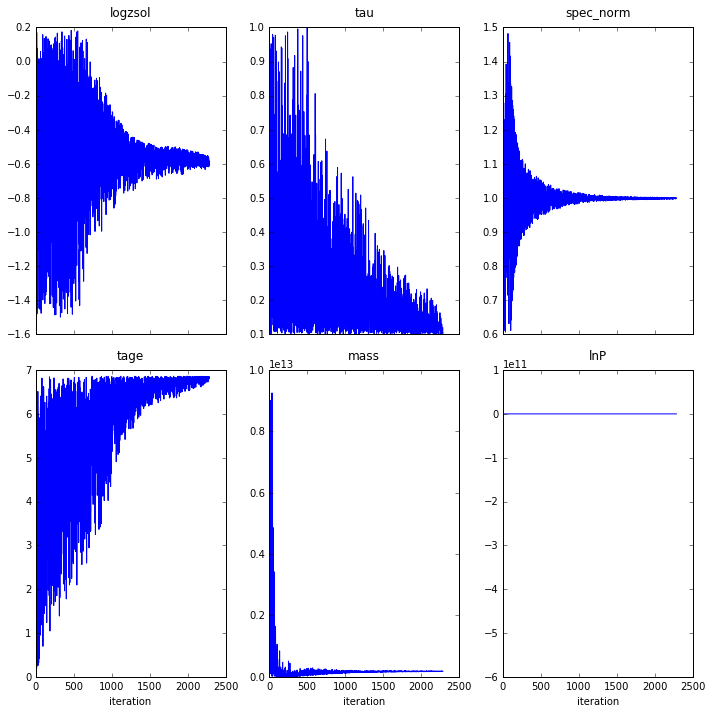

In [4]:
tracefig = traceplot(res, figsize=(10,10))

/home/anm9226/.local/lib/python2.7/site-packages/numpy/ma/core.py:6447: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/anm9226/.local/lib/python2.7/site-packages/numpy/ma/core.py:6447: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


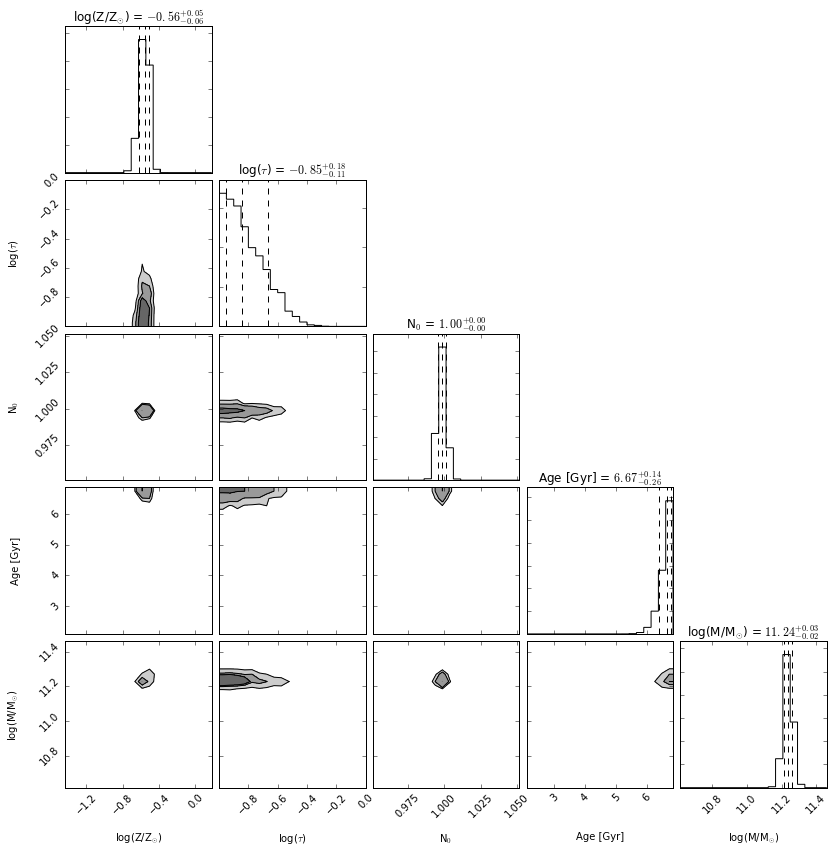

In [5]:
##### If you want to make corner plot with better titles
#parnames = np.array([r'log(Z/Z$_{\odot}$)', r'$A_V/1.086$', r'log(${\tau}$)', r'N$_0$', 
#                     'Age [Gyr]', 'log(M/M$_{\odot}$)'], dtype='U20')

#cornerfig = anya_subcorner(res, start=500, thin=1, labels=parnames,
#                           fig=plt.subplots(4,4,figsize=(10,10))[0], fontsize=100)

parnames = np.array([r'log(Z/Z$_{\odot}$)', r'log(${\tau}$)', r'N$_0$',
                     r'Age [Gyr]',r'log(M/M$_{\odot}$)'], dtype='U20')

cornerfig = anya_subcorner(res, start=500, thin=1, labels=parnames,
                           fig=plt.subplots(5,5,figsize=(12,12))[0], fontsize=100)

# Simple corner plot
#cornerfig = subcorner(res, start=500, thin=1,
#                      fig=plt.subplots(5,5,figsize=(12,12))[0], fontsize=100)

plt.show()

In [6]:
# Make the model
from prospect.models.sedmodel import PolySedModel

def load_sps(zcontinuous=1, **extras):
    from prospect.sources import CSPSpecBasis
    sps = CSPSpecBasis(zcontinuous=zcontinuous)
    return sps

def load_model(object_redshift=0.788, add_dust=False,
               add_neb=True, opt_spec=True, luminosity_distance=None, **extras):
    model_params = TemplateLibrary["parametric_sfh"]

    #fixed values
    model_params["imf_type"]["init"] = 1 # Chabrier
    model_params["dust_type"]["init"] = 1 # Milky Way extinction law
    model_params["sfh"]["init"] = 4 # non delayed-tau 
    model_params["logzsol"]["isfree"] = True
    #model_params["logzsol"]["init"] = 0.0
    model_params["tau"]["isfree"] = True
    #model_params["tau"]["init"] = 1.0
    model_params["dust2"]["isfree"] = False
    model_params["dust2"]["init"] = 0.0
    
    
    # adjust priors
    model_params["tau"]["prior"] = priors.LogUniform(mini=0.1, maxi=1.0)
    model_params["mass"]["prior"] = priors.LogUniform(mini=1e10, maxi=1e13)
    model_params["tage"]["prior"] = priors.TopHat(mini=0, maxi=6.860)
    model_params["logzsol"]["prior"] = priors.TopHat(mini=-1.5,maxi=0.19)
    #model_params["dust2"]["prior"] = priors.TopHat(mini=0,maxi=2)

    
    # Setting redshift
    if object_redshift is not None:
        model_params["zred"]['isfree'] = False
        model_params["zred"]['init'] = object_redshift

    # Add nebular emission parameters and turn nebular emission on
    if add_neb:
        model_params.update(TemplateLibrary["nebular"]) 
        
    if opt_spec:
        model_params.update(TemplateLibrary["optimize_speccal"])
        # fit for normalization of spectrum
        model_params['spec_norm'] = {'N': 1,'init': 1.0,'isfree': True,'prior': 
                                     priors.Normal(sigma=0.2, mean=1.0), 'units': 'f_true/f_obs'}
        # Increase the polynomial size to 15
        model_params['polyorder'] = {'N': 1, 'init': 12,'isfree': False}
        run_params["opt_spec"] = True
    
        # Now instantiate the model using this new dictionary of parameter specifications
        model = PolySedModel(model_params)
        
    elif opt_spec == False:
        model = SedModel(model_params)
        run_params["opt_spec"] = False
        
    return model


In [7]:
# Instantiate the model
mod = load_model(**run_params)
sps = load_sps(**run_params)

In [8]:
# Making/ Normalizing/ Converting Model and Observed Data
flatchain = res['chain']

post_pcts = [quantile(flatchain[:, i], percents=50, weights=res.get("weights", None))
             for i in range(mod.ndim)]

# Converged spectrum and photometric values
mspec_conv, mphot_conv, _ = mod.mean_model(post_pcts, obs, sps=sps)

# Photometry
wphot = obs["phot_wave"] # Model/Observed photometric wavelengths
obsphot = obs['maggies']*3631e6 # Converted Observed photometry
obsphot_unc = obs['maggies_unc']*3631e6 # Converted Observed Photometry error
obswave = obs['wavelength'] # Observed Spectrum Wavelengths
modphot = mphot_conv * 3631e6

# If observed spectrum was used in fit
if run_params["opt_spec"] == True:
    mod_cal = mod._speccal # Normalization factor
    norm_model_spec = (mspec_conv/mod_cal) * 3631e6 # Normalized model spectrum
    wspec = obs["wavelength"] # Model spectrum Wavelength (Same as obs wavelength)
    obsspec = (obs['spectrum']/mod_cal) * 3631e6 # Observed Spectrum
    obserr = (obs['unc']/mod_cal) * 3631e6 # Observed Spectrum Error
    

# If observed spectrum was NOT used in fit
elif run_params["opt_spec"] == False:
    a = 1 + mod.params.get('zred') 
    wspec = sps.wavelengths.copy()
    wspec *= a #redshift them
    mspec_conv *= 3631e6 # Converted model spectrum

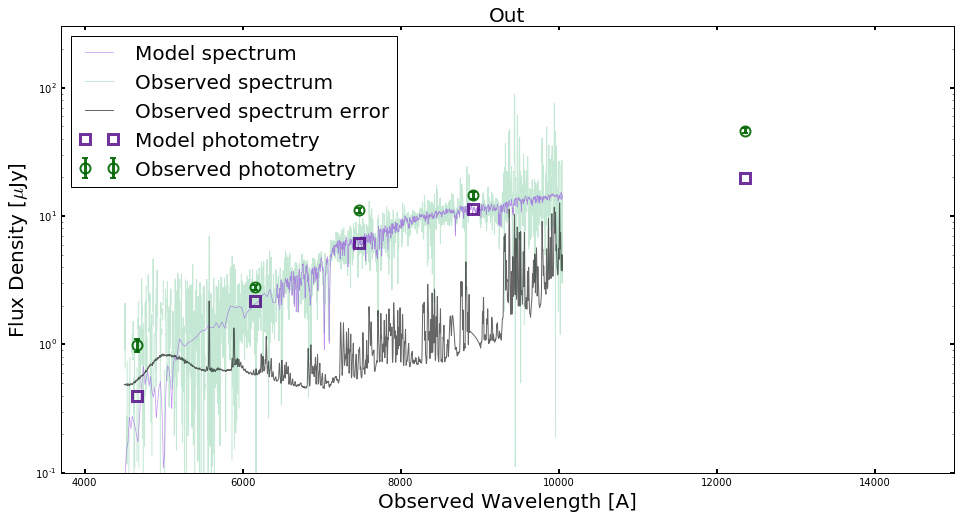

In [10]:
# Make plot of data and model
plt.figure(figsize=(16,8))


if run_params["opt_spec"] == True:
    # Model spectrum
    plt.semilogy(wspec, norm_model_spec, label='Model spectrum', lw=0.7, color='blueviolet', alpha=0.5, zorder=1)
    # Observed spectrum
    plt.semilogy(obswave, obsspec, color='mediumseagreen', alpha=0.3, 
             zorder=0, label='Observed spectrum')
    # Observed spectrum error
    plt.semilogy(obswave, obserr, color='k', alpha=0.6, zorder=0, label='Observed spectrum error')
    # Model photometry
    plt.errorbar(wphot, modphot, label='Model photometry',
                 marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
                 markerfacecolor='none', markeredgecolor='indigo', markeredgewidth=3, zorder=2)
    # Observed photometry and error
    plt.errorbar(wphot, obsphot, yerr=obsphot_unc, label='Observed photometry', 
                 ecolor='darkgreen', marker='o', markersize=10, ls='', lw=3, alpha=0.9, markerfacecolor='none', 
                 markeredgecolor='darkgreen', markeredgewidth=2, zorder=3)
    
elif run_params["opt_spec"] == False:
    # Model spectrum
    plt.semilogy(wspec, mspec_conv, label='Model spectrum', lw=0.7, color='blueviolet', alpha=0.5, zorder=1)
    # Model photometry
    plt.errorbar(wphot, modphot, label='Model photometry',
                 marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
                 markerfacecolor='none', markeredgecolor='indigo', markeredgewidth=3, zorder=2)
    # Observed photometry and error
    plt.errorbar(wphot, obsphot, yerr=obsphot_unc, label='Observed photometry', 
                 ecolor='darkgreen', marker='o', markersize=10, ls='', lw=3, alpha=0.9, markerfacecolor='none', 
                 markeredgecolor='darkgreen', markeredgewidth=2, zorder=3)

    
twomass = ['twomass_H', 'twomass_Ks']
filts = load_filters(twomass)
waves = np.array([f.wave_effective for f in filts])
uls = np.array([22.8, 22.4])

#plt.errorbar(waves[0], 10**(-0.4*uls[0])*3631e6, color='darkgreen', marker='v', markersize=20)
#plt.errorbar(waves[1], 10**(-0.4*uls[1])*3631e6, color='darkgreen', marker='v', markersize=20)


#plt.plot(4717.8236, 10**(-0.4*25.5)*3631e6, marker='v', markersize=20,color='darkgreen')
plt.xlabel('Observed Wavelength [A]',fontsize =20)
plt.ylabel(r'Flux Density [$\mu$Jy]',fontsize =20)
plt.title('Out',fontsize =20)
plt.xlim(3.7e3, 15e3)
plt.ylim(1e-1, 3e2)
plt.legend(loc='best', fontsize=20)
ax = plt.gca()
ax.tick_params(width=2)

# If you want to change where tick marks are/size
#ticks = [2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000]
#xticks(ticks, ('2000', '3000', '4000', '5000', '6000', '7000', '8000', '9000'), fontsize=14)
#yticks(fontsize=14)


plt.show()